# Audio Recognition
### Tim Nguyen & Neeraj Shah
---


In the following code portions below, we implement a barebones version of how audio recognition works using the core concept sof digital signal processing.  This involves sampling the analog signal (sound input), converting it a digital signal, performing a discrete fourier transform, and matching the audio fingerprints with a predefined database.

### Dependencies

1) Need to have PyAudio library.  Install with python's package manager `pip` :

`pip install pyaudio`



In [1]:
# Import required libraries

from sys import byteorder
from array import array
import pylab
import time
import copy
import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile


In [2]:
# Sample the songs in the library to create the TRUE database.



## Code below deals with audio input

Records audio and saves to a .WAV file for a specified amount of seconds.

In [3]:
def record(fileName):
    
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100  # Sampling Rate
    RECORD_SECONDS = 10
    WAVE_OUTPUT_FILENAME = fileName

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("Recording Audio ... ")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("Recording Finished")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    
def play(fileName):

    wf = wave.open(fileName, 'rb')

    p = pyaudio.PyAudio()

    def callback(in_data, frame_count, time_info, status):
        data = wf.readframes(frame_count)
        return (data, pyaudio.paContinue)

    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True,
                    stream_callback=callback)

    stream.start_stream()

    i = 0
    # while stream.is_active():
    while i < 125:
        time.sleep(0.1)
        i += 1

    stream.stop_stream()
    stream.close()
    wf.close()

    p.terminate()

In [57]:
record("test.wav")  # Test record

Recording Audio ... 
Recording Finished


In [24]:
play("test.wav")

# Plot Frequencies

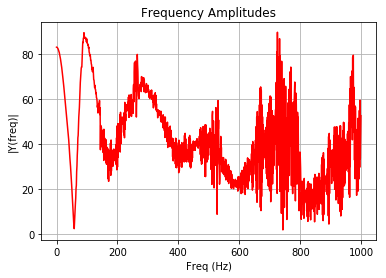

In [53]:
sample_rate, X = wavfile.read('test.wav')
#print(sample_rate)
n = 44100
Fs = 44100
sec = X[:n]
secTrans = np.fft.fft(sec)/n
secTrans = secTrans[range(n/2)]

k = np.arange(n) 
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range
#print(len(secTrans))
#print(len(frq))
#print(max(frq))
plt.plot(frq[:1000],abs(secTrans[:1000]),'r') # plotting the spectrum
#plt.plot(11274,392,'bo')
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')
plt.title('Frequency Amplitudes')

plt.show()
plt.grid()

big = 0
for i in range(len(secTrans[0:1000])):
    if (abs(secTrans[i]) > big):
        big = i
        
#print(secTrans[11274])
max1 = np.argmax(abs(secTrans[0:200]))
max2 = np.argmax(abs(secTrans[200:600])) + 200
#max1 = np.argmax(abs(secTrans[400:1000]))
#print(max1)
#print(max2)

# plt.pcolormesh(times, frequencies, spectogram)
# plt.imshow(spectogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

## Build Database Here:

The database will store several snippets of the songs we wish to be able to recognize.
We will use a hashtable, where the key is several high frequencies and value is an array of time and song.
We will choose high frequencies between several intervals. Each key will have four frequencies.

Our frequency ranges will be from 0-40Hz, 40-80Hz, 80-120Hz, and 120Hz+
In the future, we may modify this to include more songs.
Each snippet from which we obtain frequencies will be one second long.
Since this is such a small frame of time, we can ignore time from here on out.
The only place time will be included is in the value of our hashtable. It can show us exactly where
program associated our recorded sound with our stored song. This is useful for debugging

Even with a four-point key, we still may not completely recognize a song--two sets of four frequencies may map to the same song. This is when it will useful to make multiple matches. We will track all associations and narrow the pool the longer we play the song. At the end, we should have correctly identified a song.

In [28]:
database = {}
maxChunk = 44100 #How large each of our sections are


#-----

songSnippet = []
sample_rate, X = wavfile.read('moon.wav')
song = X[:,0]
Fs = 44100

secs = 1

print(len(song))

for i in range(len(song)):
    songSnippet.append(song[i])
    if i > secs*maxChunk:
        secs += 1
        #Know associated time passed
        # Take fft here (songSnippet)
        songSnipTrans = np.fft.fft(songSnippet)/maxChunk
        songSnipTrans = songSnipTrans[range(maxChunk/2)]
        
        
        k = np.arange(maxChunk) 
        T = maxChunk/Fs
        frq = k/T # two sides frequency range
        frq = frq[range(maxChunk/2)] # one side frequency range

        #print(secTrans[11274])
        # Find Maximums.

        max1 = np.argmax(abs(songSnipTrans[0:500]))
        max2 = np.argmax(abs(songSnipTrans[500:1000])) + 500


        if (max1, max2) in database:
            database[(max1, max2)].add('moon.wav')
        else:
            database[(max1, max2)] = set(['moon.wav'])


        #Reset
        songSnippet = []


songSnippet = []
sample_rate, X = wavfile.read('billiejeanwav.wav')
song = X[:,0]
Fs = 44100

secs = 1

print(len(song))

for i in range(len(song)):
    songSnippet.append(song[i])
    if i > secs*maxChunk:
        secs += 1
        #Know associated time passed
        # Take fft here (songSnippet)
        songSnipTrans = np.fft.fft(songSnippet)/maxChunk
        songSnipTrans = songSnipTrans[range(maxChunk/2)]
        
        
        k = np.arange(maxChunk) 
        T = maxChunk/Fs
        frq = k/T # two sides frequency range
        frq = frq[range(maxChunk/2)] # one side frequency range

        #print(secTrans[11274])
        # Find Maximums.


        max1 = np.argmax(abs(songSnipTrans[0:500]))
        max2 = np.argmax(abs(songSnipTrans[500:1000])) + 500
        
        if (max1, max2) in database:
            database[(max1, max2)].add('billiejeanwav.wav')
        else:
            database[(max1, max2)] = set(['billiejeanwav.wav'])
        #Reset
        songSnippet = []

        
print("")

6553728
12973871



In [35]:
database

{(45, 890): {'moon.wav'},
 (46, 508): {'moon.wav'},
 (46, 707): {'moon.wav'},
 (48, 515): {'moon.wav'},
 (60, 554): {'billiejeanwav.wav'},
 (60, 564): {'billiejeanwav.wav'},
 (61, 502): {'billiejeanwav.wav'},
 (61, 504): {'billiejeanwav.wav'},
 (61, 508): {'billiejeanwav.wav'},
 (61, 511): {'billiejeanwav.wav'},
 (61, 565): {'billiejeanwav.wav'},
 (62, 538): {'billiejeanwav.wav'},
 (62, 553): {'billiejeanwav.wav'},
 (62, 567): {'billiejeanwav.wav'},
 (62, 754): {'billiejeanwav.wav'},
 (62, 766): {'billiejeanwav.wav'},
 (63, 506): {'billiejeanwav.wav'},
 (63, 565): {'billiejeanwav.wav'},
 (63, 567): {'billiejeanwav.wav'},
 (63, 753): {'billiejeanwav.wav'},
 (64, 561): {'billiejeanwav.wav'},
 (65, 501): {'billiejeanwav.wav'},
 (65, 758): {'billiejeanwav.wav'},
 (65, 890): {'billiejeanwav.wav'},
 (66, 557): {'billiejeanwav.wav'},
 (66, 561): {'billiejeanwav.wav'},
 (66, 568): {'billiejeanwav.wav'},
 (66, 854): {'billiejeanwav.wav'},
 (67, 502): {'billiejeanwav.wav'},
 (67, 503): {'billiej

## The Actual Program
Keep track of "matches" and narrow song options as the song plays for a longer time. In the best case scenario, it should only need to play for the size of one song snippet.  

In [56]:
sample_rate, X = wavfile.read('test.wav')
leftChannel = X[:]
inputSnippet = []

firstTime = 1
secs = 1
associatedSongs = set()

print(len(leftChannel))

maxChunk = 44100 #How large each of our sections are

print("Beginning Music Recognition Algorithm ...\n")
for i in range(len(leftChannel)):
    
    inputSnippet.append(leftChannel[i])
    if i > secs*maxChunk:
        secs += 1
        #Know associated time passed
        # Take fft here (songSnippet)
        inputSnipTrans = np.fft.fft(inputSnippet)/maxChunk
        inputSnipTrans = inputSnipTrans[range(maxChunk/2)]
        
        
        k = np.arange(maxChunk) 
        T = maxChunk/Fs
        frq = k/T # two sides frequency range
        frq = frq[range(maxChunk/2)] # one side frequency range

        #print(secTrans[11274])
        # Find Maximums.


        max1 = np.argmax(abs(inputSnipTrans[0:500]))
        max2 = np.argmax(abs(inputSnipTrans[500:1000])) + 500
        print(max1, max2)


        threshold = int((max1 + max2)/2 * .1) # Threshold is plus or minus 20 Hz

        associatedSongs = set(associatedSongs)
    
        if firstTime:
            match2 = 0
            for i in range(2*threshold):
                first = max1 - threshold + i
                for j in range(2*threshold):
                    second = max2 - threshold + j
                    
                    if ((first,second)) in database:
                        print("match at %d %d : adding %s" %(first, second, database[(first,second)]))
                        associatedSongs = associatedSongs.union(database[(first, second)])
                        match2 += 1

            print("DEBUG First : " + str(associatedSongs))

            firstTime = 0
        else:

            secondAssociatedSongs = set()
            for i in range(2*threshold):
                first = max1 - threshold + i
                for j in range(2*threshold):
                    second = max2 - threshold + j

                    if ((first, second)) in database:                
                         secondAssociatedSongs = secondAssociatedSongs.union(database[(first, second)])
            print("DEBUG Second : " + str(secondAssociatedSongs))

            if len(secondAssociatedSongs) == 0:
                continue
            else:
                print("DEBUG Total : " + str(secondAssociatedSongs))
                associatedSongs = associatedSongs & secondAssociatedSongs

        print "DEBUG : " + str(associatedSongs)



        #store all associated songs within this array
        #add noise here--in other words, allow matches to be within plus-or-minus five percent of obtained frequency.
        #This will increase the number of matches, but will make sure we don't reject the right song (Type 2 error)
        #We don't add new matches after the first snippet of playback time. 

        #Continue to find matches till there is only one element left in the array.

        if len(associatedSongs) == 1:

            print("\nThe matched song is : %s " % (list(associatedSongs)[0]))
            break

        secs += 1
        inputSnippet = []

440320
Beginning Music Recognition Algorithm ...

(90, 725)
match at 62 754 : adding set(['billiejeanwav.wav'])
match at 63 753 : adding set(['billiejeanwav.wav'])
match at 65 758 : adding set(['billiejeanwav.wav'])
match at 67 740 : adding set(['billiejeanwav.wav'])
match at 68 744 : adding set(['billiejeanwav.wav'])
match at 69 747 : adding set(['billiejeanwav.wav'])
match at 69 748 : adding set(['billiejeanwav.wav'])
match at 69 753 : adding set(['billiejeanwav.wav'])
match at 69 754 : adding set(['billiejeanwav.wav'])
match at 69 759 : adding set(['billiejeanwav.wav'])
match at 69 761 : adding set(['billiejeanwav.wav'])
match at 70 753 : adding set(['billiejeanwav.wav'])
match at 70 756 : adding set(['billiejeanwav.wav'])
match at 70 757 : adding set(['billiejeanwav.wav'])
match at 72 756 : adding set(['billiejeanwav.wav'])
match at 73 759 : adding set(['billiejeanwav.wav'])
match at 74 751 : adding set(['billiejeanwav.wav'])
match at 74 762 : adding set(['billiejeanwav.wav'])
matc

In [58]:
sample_rate, X = wavfile.read('test.wav')
leftChannel = X[:]
inputSnippet = []

firstTime = 1
secs = 1
associatedSongs = set()

print(len(leftChannel))

maxChunk = 44100 #How large each of our sections are

print("Beginning Music Recognition Algorithm ...\n")
for i in range(len(leftChannel)):
    
    inputSnippet.append(leftChannel[i])
    if i > secs*maxChunk:
        secs += 1
        #Know associated time passed
        # Take fft here (songSnippet)
        inputSnipTrans = np.fft.fft(inputSnippet)/maxChunk
        inputSnipTrans = inputSnipTrans[range(maxChunk/2)]
        
        
        k = np.arange(maxChunk) 
        T = maxChunk/Fs
        frq = k/T # two sides frequency range
        frq = frq[range(maxChunk/2)] # one side frequency range

        #print(secTrans[11274])
        # Find Maximums.


        max1 = np.argmax(abs(inputSnipTrans[0:500]))
        max2 = np.argmax(abs(inputSnipTrans[500:1000])) + 500
        print(max1, max2)


        threshold = int((max1 + max2)/2 * .01) # Threshold is plus or minus 20 Hz

        associatedSongs = set(associatedSongs)
    
        if firstTime:
            match2 = 0
            for i in range(2*threshold):
                first = max1 - threshold + i
                for j in range(2*threshold):
                    second = max2 - threshold + j
                    
                    if ((first,second)) in database:
                        print("match at %d %d : adding %s" %(first, second, database[(first,second)]))
                        associatedSongs = associatedSongs.union(database[(first, second)])
                        match2 += 1

            print("DEBUG First : " + str(associatedSongs))

            firstTime = 0
        else:

            secondAssociatedSongs = set()
            for i in range(2*threshold):
                first = max1 - threshold + i
                for j in range(2*threshold):
                    second = max2 - threshold + j

                    if ((first, second)) in database:                
                         secondAssociatedSongs = secondAssociatedSongs.union(database[(first, second)])
            print("DEBUG Second : " + str(secondAssociatedSongs))

            if len(secondAssociatedSongs) == 0:
                continue
            else:
                print("DEBUG Total : " + str(secondAssociatedSongs))
                associatedSongs = associatedSongs & secondAssociatedSongs

        print "DEBUG : " + str(associatedSongs)



        #store all associated songs within this array
        #add noise here--in other words, allow matches to be within plus-or-minus five percent of obtained frequency.
        #This will increase the number of matches, but will make sure we don't reject the right song (Type 2 error)
        #We don't add new matches after the first snippet of playback time. 

        #Continue to find matches till there is only one element left in the array.

        if len(associatedSongs) == 1:

            print("\nThe matched song is : %s " % (list(associatedSongs)[0]))
            break

        secs += 1
        inputSnippet = []

440320
Beginning Music Recognition Algorithm ...

(95, 503)
match at 93 501 : adding set(['billiejeanwav.wav'])
match at 94 502 : adding set(['billiejeanwav.wav'])
match at 94 503 : adding set(['billiejeanwav.wav'])
match at 94 504 : adding set(['billiejeanwav.wav'])
match at 95 503 : adding set(['billiejeanwav.wav'])
DEBUG First : set(['billiejeanwav.wav'])
DEBUG : set(['billiejeanwav.wav'])

The matched song is : billiejeanwav.wav 
